<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/DEEPCTR02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



深度兴趣网络（Deep Interest Network, DIN）是阿里巴巴在2018年提出的一种用于点击率预测（CTR）的深度学习模型。其核心思想可以用一个生活化的比喻来理解：想象你是一位网购爱好者，平台需要根据你过去浏览的商品（比如运动鞋、咖啡机、小说）来猜测你现在可能对哪个广告感兴趣。传统方法就像把所有历史行为“一视同仁”地分析，但DIN却能像人类一样，**动态关注与当前广告最相关的行为**。例如，当你看到一款新跑鞋广告时，DIN会重点参考你过去浏览运动鞋的记录，而忽略咖啡机和小说这类无关行为。

### 一、DIN解决了什么问题？
点击率预测（CTR）是推荐系统和广告投放的核心任务，目标是预测用户点击某个内容（如广告、商品）的概率。传统模型（如逻辑回归、因子分解机）存在两大局限：
1. **兴趣建模僵化**：用户的历史行为被压缩成固定长度的向量，无法灵活表达多样的兴趣。例如，用户可能同时喜欢“运动”和“文学”，但传统模型难以区分这两种兴趣在不同场景下的权重。
2. **噪声干扰**：用户行为中混杂大量无关历史（例如误点或随意浏览），传统模型无法有效过滤这些噪声。

### 二、DIN的核心创新：像人一样“动态关注”
DIN通过以下三个关键设计解决上述问题：
1. **注意力机制（Attention）**  
   这是DIN的灵魂。模型会为每个用户行为计算一个“相关性权重”：与当前广告越相关的行为，权重越高。例如，用户的历史行为包括“运动鞋、咖啡机、小说”，当预测跑鞋广告的点击率时，模型会给“运动鞋”行为赋予高权重，而“咖啡机”和“小说”的权重则很低。这就像人类看到广告时，只会回想相关的购买经历。

2. **自适应激活函数（Dice）**  
   传统激活函数（如ReLU）的阈值是固定的，但DIN的Dice函数能根据数据分布动态调整阈值。例如，当用户行为数据差异较大时，Dice会自动适应不同场景，提升模型的灵活性。

3. **高效正则化（Mini-batch Aware Regularization）**  
   面对海量数据，传统正则化方法计算成本极高。DIN只对当前训练批次（mini-batch）中出现过的特征进行正则化，既防止过拟合，又大幅减少计算量。

### 三、DIN的实际效果如何？
实验表明，DIN在多个场景下显著优于传统模型：
- **离线测试**：在亚马逊和MovieLens数据集上，DIN的AUC（衡量预测准确性的指标）比传统模型（如Wide&Deep、PNN）提升约1.89%。
- **线上应用**：在阿里巴巴广告系统中，DIN使点击率（CTR）提升10%，广告收入增长3.8%。这意味着每展示100次广告，DIN能多带来1次点击，这在亿级流量场景下效益巨大。

### 四、DIN的启示：从“静态画像”到“动态兴趣”
DIN的成功揭示了推荐系统的未来方向：**用户的兴趣是多样且动态变化的**。与其用固定标签定义用户（如“运动爱好者”），不如根据具体场景实时捕捉兴趣焦点。这种思路也被后续模型（如DIEN）进一步扩展，加入了兴趣演化的时序建模。

总结来说，DIN的核心思想是 **“动态相关性”** ——让模型像人一样，在不同场景下灵活关注最相关的历史行为，从而更精准地预测用户的点击意愿。这一创新不仅提升了技术指标，也推动了推荐系统从“粗放推荐”向“智能理解”的跨越。

In [1]:
import torch

# 生成一个包含 10 个随机整数的一维张量，范围是 [0, 10)
random_tensor = torch.randint(0, 10, (10,))
print(random_tensor)

# 生成一个 3x2 的二维张量，范围是 [1, 5)
random_tensor_2d = torch.randint(1, 5, (3, 2))
print(random_tensor_2d)

tensor([3, 0, 8, 4, 1, 1, 5, 9, 9, 1])
tensor([[4, 3],
        [3, 4],
        [1, 3]])


**unsqueeze(1) 的作用？**

unsqueeze(1) 是 PyTorch 张量的一个方法，用于在指定维度上增加一个维度。1 表示在第二个维度（索引为 1）上增加维度。

例如，假设有一个形状为 (64,) 的张量 user_ages，表示 64 个用户的年龄。执行 user_ages.unsqueeze(1) 后，张量的形状会变成 (64, 1)。相当于把原来的一维张量变成了一个二维张量，其中每个元素都被放在一个单独的行中。

**为什么需要增加一个维度？**

在深度学习模型中，输入数据的维度通常需要满足特定的要求。例如，在 DIN 模型中，用户的年龄和商品价格都是数值型特征，通常会使用一个线性层来处理这些特征。线性层的输入需要是一个二维张量，其中第一维表示样本数量，第二维表示特征维度。

因此，如果用户的年龄或商品价格只有一维，就需要使用 unsqueeze(1) 在第二个维度上增加一个维度，使其变成一个二维张量，以便与线性层的输入维度匹配。

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 定义模型的超参数
embedding_dim = 32  # Embedding 向量的维度，每个用户/商品/类别都会被映射到一个 32 维的向量
hidden_units = [64, 32]  # 全连接层隐藏单元数量，表示网络中两个隐藏层的节点数
num_users = 1000  # 用户总数
num_items = 2000  # 商品总数
num_categories = 10  # 商品类别总数


# 定义一个函数来生成模拟数据
def generate_sample_data(batch_size=64):
    # 生成用户 ID，范围在 [0, num_users) 之间，形状为 (batch_size,)
    user_ids = torch.randint(0, num_users, (batch_size,))
    # 生成用户性别，0 或 1，形状为 (batch_size,)
    user_genders = torch.randint(0, 2, (batch_size,))
    # 生成用户年龄，范围在 [18, 60) 之间，形状为 (batch_size,)，并转换为浮点数
    user_ages = torch.randint(18, 60, (batch_size,)).float()

    # 生成商品 ID，范围在 [0, num_items) 之间，形状为 (batch_size,)
    item_ids = torch.randint(0, num_items, (batch_size,))
    # 生成商品类别，范围在 [0, num_categories) 之间，形状为 (batch_size,)
    item_categories = torch.randint(0, num_categories, (batch_size,))
    # 生成商品价格，范围在 [0, 1000) 之间，形状为 (batch_size,)
    item_prices = torch.rand(batch_size) * 1000

    # 生成用户的历史行为序列，每个用户随机浏览 1-5 个商品
    history_item_ids_list = []
    for _ in range(batch_size):
        # 随机生成序列长度，范围在 [1, 6) 之间
        seq_len = torch.randint(1, 6, (1,)).item()
        # 生成历史行为序列，范围在 [0, num_items) 之间，形状为 (seq_len,)
        history_seq = torch.randint(0, num_items, (seq_len,))
        # 将生成的序列添加到列表中
        history_item_ids_list.append(history_seq)

    # 将历史行为序列填充到相同长度 (最长序列长度)，并转换为张量
    # 获取最长序列长度
    max_len = max([seq.size(0) for seq in history_item_ids_list])
    # 创建一个全零张量，形状为 (batch_size, max_len)，用于存储填充后的序列
    padded_history_item_ids = torch.zeros((batch_size, max_len), dtype=torch.long)
    # 遍历每个用户的历史行为序列
    for i, seq in enumerate(history_item_ids_list):
        # 将序列填充到 padded_history_item_ids 中
        padded_history_item_ids[i, :seq.size(0)] = seq

    # 生成目标商品 ID，范围在 [0, num_items) 之间，形状为 (batch_size,)
    target_item_ids = torch.randint(0, num_items, (batch_size,))
    # 生成点击标签，0 或 1，形状为 (batch_size,)，并转换为浮点数
    labels = torch.randint(0, 2, (batch_size,)).float()

    # 将所有数据打包成一个字典返回
    return {
        'user_id': user_ids,
        'user_gender': user_genders,
        'user_age': user_ages.unsqueeze(1),  # 增加一个维度，以便与模型输入匹配
        'item_id': item_ids,
        'item_category': item_categories,
        'item_price': item_prices.unsqueeze(1),  # 增加一个维度，以便与模型输入匹配
        'history_item_ids': padded_history_item_ids,
        'target_item_id': target_item_ids,
        'label': labels
    }

# 调用 generate_sample_data 函数生成一个 batch 的数据
sample_data = generate_sample_data()
# 打印示例数据的键值，以便查看数据结构
print("示例数据：", sample_data.keys())
# 打印历史行为序列的形状，以便查看数据维度
print("历史行为序列形状:", sample_data['history_item_ids'].shape)

示例数据： dict_keys(['user_id', 'user_gender', 'user_age', 'item_id', 'item_category', 'item_price', 'history_item_ids', 'target_item_id', 'label'])
历史行为序列形状: torch.Size([64, 5])


**nn.Embedding 的工作原理**

nn.Embedding 层的作用是将离散的特征（例如商品 ID）映射成连续的向量表示（embedding 向量）。它内部维护一个查找表，表中的每一行代表一个特征的 embedding 向量。

当我们输入一个特征 ID 时，nn.Embedding 层会根据这个 ID 在查找表中找到对应的 embedding 向量并返回。

**处理不同维度输入的关键**

nn.Embedding 层可以处理任意形状的整数张量作为输入。它会将输入张量中的每个元素都视为一个特征 ID，并根据 ID 查找对应的 embedding 向量。

处理 item_id: item_id 的形状是 (batch_size,)，它包含了每个样本的商品 ID。nn.Embedding 层会将 item_id 中的每个 ID 都映射成一个 embedding 向量，最终返回一个形状为 (batch_size, embedding_dim) 的张量。

处理 history_item_ids: history_item_ids 的形状是 (batch_size, seq_len)，它包含了每个样本的历史行为序列，序列中的每个元素都是一个商品 ID。nn.Embedding 层会将 history_item_ids 中的每个 ID 都映射成一个 embedding 向量，最终返回一个形状为 (batch_size, seq_len, embedding_dim) 的张量。

**总结**

nn.Embedding 层能够处理不同维度的输入，因为它会将输入张量中的每个元素都视为一个特征 ID，并根据 ID 查找对应的 embedding 向量。

因此，即使 item_id 和 history_item_ids 的维度不同，item_embedding 函数仍然可以处理它们，并返回相应形状的 embedding 向量张量。

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DIN(nn.Module):
    def __init__(self, num_users, num_items, num_categories, embedding_dim, hidden_units):
        super(DIN, self).__init__()

        # 创建用户嵌入层，将用户ID映射到embedding_dim维度的向量空间
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        # 创建商品嵌入层，将商品ID映射到embedding_dim维度的向量空间
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # 创建类别嵌入层，将类别ID映射到embedding_dim维度的向量空间
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)

        # 创建数值型特征的线性层，将用户年龄和商品价格映射到embedding_dim维度的向量空间
        self.numerical_fc = nn.Linear(2, embedding_dim)

        # 创建注意力池化层，用于根据目标商品对历史行为进行加权
        self.attention_pooling = AttentionPoolingLayer(embedding_dim)

        # 创建全连接层，用于最终的点击率预测
        fc_layers = []
        # 初始化全连接层的输入维度，包括用户、商品、类别、数值型特征和注意力输出的embedding维度之和
        input_dim = embedding_dim * 4 + embedding_dim
        # 逐层构建全连接层，并使用ReLU作为激活函数
        for units in hidden_units:
            fc_layers.append(nn.Linear(input_dim, units))
            fc_layers.append(nn.ReLU())
            input_dim = units
        # 添加最后一层全连接层，输出维度为1，表示点击率预测值
        fc_layers.append(nn.Linear(input_dim, 1))
        # 将所有全连接层组合成一个序列
        self.fc = nn.Sequential(*fc_layers)


    def forward(self, user_id, user_gender, user_age, item_id, item_category, item_price, history_item_ids, target_item_id):
        """
        DIN模型的前向传播函数

        输入:
            user_id: 用户ID, 形状: (batch_size,)
            user_gender: 用户性别, 形状: (batch_size,)
            user_age: 用户年龄, 形状: (batch_size, 1)
            item_id: 商品ID, 形状: (batch_size,)
            item_category: 商品类别, 形状: (batch_size,)
            item_price: 商品价格, 形状: (batch_size, 1)
            history_item_ids: 用户历史行为序列, 形状: (batch_size, seq_len)
            target_item_id: 目标商品ID, 形状: (batch_size,)

        输出:
            output: 点击率预测值, 形状: (batch_size,)
        """
        # 1. 获取各个特征的嵌入向量
        # 获取用户嵌入向量
        user_embed = self.user_embedding(user_id)
        # 获取商品嵌入向量
        item_embed = self.item_embedding(item_id)
        # 获取类别嵌入向量
        category_embed = self.category_embedding(item_category)
        # 获取目标商品嵌入向量
        target_item_embed = self.item_embedding(target_item_id)
        # 获取历史行为序列嵌入向量
        history_item_embed = self.item_embedding(history_item_ids)


        # 2. 处理数值型特征
        # 将用户年龄和商品价格拼接成一个张量
        numerical_features = torch.cat([user_age, item_price], dim=-1)
        # 使用线性层和ReLU激活函数将数值型特征映射到embedding_dim维度的向量空间
        numerical_embed = F.relu(self.numerical_fc(numerical_features))

        # 3. 使用注意力池化层对历史行为进行加权
        # 使用注意力机制，根据目标商品，对用户的历史行为序列进行加权聚合，得到用户的兴趣表示
        attention_output = self.attention_pooling(queries=target_item_embed, keys=history_item_embed)

        # 4. 将所有特征拼接在一起
        # 将用户、商品、类别、数值型特征和注意力输出的embedding向量拼接在一起
        concat_features = torch.cat([user_embed, item_embed, numerical_embed, attention_output, target_item_embed], dim=-1)

        # 5. 通过全连接层进行预测
        # 将拼接后的特征向量输入到全连接层，得到预测结果
        output = self.fc(concat_features)
        # 使用 sigmoid 激活函数将输出转换为点击率 (0-1)
        output = torch.sigmoid(output)

        # 返回预测结果，并移除维度为 1 的维度
        return output.squeeze(1)


# 注意力池化层的实现（！存在问题！）
class AttentionPoolingLayer(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionPoolingLayer, self).__init__()
        # 创建一个线性层，将 embedding 向量映射到注意力权重
        self.attention_fc = nn.Linear(embedding_dim, 1)

    def forward(self, queries, keys):
        """
        前向传播函数，计算注意力权重并进行加权池化
        :param queries: 目标商品的嵌入向量 (batch_size, embedding_dim)
        :param keys: 历史行为序列的嵌入向量 (batch_size, seq_len, embedding_dim)
        :return: 注意力池化后的用户兴趣表示 (batch_size, embedding_dim)
        """

        # 1. 计算注意力分数
        # 扩展目标商品嵌入向量的维度，以便与历史行为序列嵌入向量进行元素乘法
        queries = queries.unsqueeze(1)  # (batch_size, 1, embedding_dim)
        # 计算目标商品与每个历史行为商品的相似度，作为注意力分数
        attention_scores = torch.sum(queries * keys, dim=-1)  # (batch_size, seq_len)

        # 2. 使用全连接层进一步学习注意力分数
        # 将历史行为序列嵌入向量进行reshape，然后通过线性层进行变换，得到新的注意力分数
        attention_scores = self.attention_fc(keys.view(-1, keys.size(-1))).view(keys.size(0), keys.size(1))  # (batch_size, seq_len)

        # 3. 使用 Softmax 归一化注意力分数，得到注意力权重
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch_size, seq_len)

        # 4. 加权求和得到注意力池化后的结果
        # 扩展注意力权重的维度，与历史行为序列嵌入向量相乘，然后在序列维度上求和
        attention_output = torch.sum(attention_weights.unsqueeze(-1) * keys, dim=1)  # (batch_size, embedding_dim)

        return attention_output

# 初始化 DIN 模型
model = DIN(num_users, num_items, num_categories, embedding_dim, hidden_units)
print(model) # 打印模型结构

DIN(
  (user_embedding): Embedding(1000, 32)
  (item_embedding): Embedding(2000, 32)
  (category_embedding): Embedding(10, 32)
  (numerical_fc): Linear(in_features=2, out_features=32, bias=True)
  (attention_pooling): AttentionPoolingLayer(
    (attention_fc): Linear(in_features=32, out_features=1, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=160, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


**queries * keys**: 这是两个张量的元素乘法操作。

queries 代表目标商品的 embedding 向量，形状为 (batch_size, 1, embedding_dim)。
keys 代表用户历史行为序列中每个商品的 embedding 向量，形状为 (batch_size, seq_len, embedding_dim)。

元素乘法操作会将 queries 和 keys 中对应位置的元素相乘，得到一个新的张量，形状为 (batch_size, seq_len, embedding_dim)。

**torch.sum(...)**: 这是对张量进行求和的操作。

dim=-1 指定了求和的维度，-1 表示最后一个维度，也就是 embedding_dim 这个维度。
因此，torch.sum(queries * keys, dim=-1) 会将 queries * keys 这个张量在 embedding_dim 维度上进行求和，得到一个新的张量，形状为 (batch_size, seq_len)。


**整体含义**:

这行代码的整体含义是计算目标商品与每个历史行为商品之间的相似度，作为注意力分数。

首先，通过元素乘法 (queries * keys) 计算目标商品 embedding 与每个历史行为商品 embedding 的对应元素乘积。

然后，通过在 embedding_dim 维度上求和 (torch.sum(...)) 得到一个标量值，这个标量值代表了目标商品与某个历史行为商品之间的相似度。

最终得到的张量 attention_scores 形状为 (batch_size, seq_len)，其中每个元素都代表目标商品与对应历史行为商品的相似度（注意力分数）。

**直观理解**：

可以将 queries 看作是目标商品的“查询向量”，将 keys 看作是历史行为商品的“键向量”。torch.sum(queries * keys, dim=-1) 的作用就是计算“查询向量”与每个“键向量”之间的相似度，相似度越高，注意力分数就越高，说明目标商品与该历史行为商品越相关。

In [4]:
# 使用示例数据进行一次前向预测
model.eval() # 设置模型为评估模式 (不进行梯度计算)
with torch.no_grad(): # 上下文管理器，禁止梯度计算
    input_data = {k: v for k, v in sample_data.items() if k != 'label'}
    predictions = model(**input_data) # 将 input_data 字典作为参数传入模型
    print("预测结果 (前 10 个样本):", predictions[:10])
    print("预测结果形状:", predictions.shape)

预测结果 (前 10 个样本): tensor([4.5698e-01, 2.5763e-03, 5.2270e-03, 1.6382e-04, 1.5215e-02, 4.5323e-03,
        2.8371e-01, 2.4951e-02, 3.9270e-01, 6.4684e-03])
预测结果形状: torch.Size([64])


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score

# 定义模型的超参数
embedding_dim = 32   # Embedding 向量的维度
hidden_units = [64, 32]   # 全连接层隐藏单元数量
num_users = 1000   # 用户总数
num_items = 2000   # 商品总数
num_categories = 50   # 商品类别总数
num_genders = 2 # 用户性别数量

# 定义一个函数来生成模拟数据
def generate_sample_data(batch_size=64):
    # 生成用户 ID
    user_ids = torch.randint(0, num_users, (batch_size,))
    # 生成用户性别
    user_genders = torch.randint(0, num_genders, (batch_size,))
    # 生成用户年龄
    user_ages = torch.randint(18, 60, (batch_size,)).float()

    # 生成商品 ID
    item_ids = torch.randint(0, num_items, (batch_size,))
    # 生成商品类别
    item_categories = torch.randint(0, num_categories, (batch_size,))
    # 生成商品价格
    item_prices = torch.rand(batch_size) * 1000

    # 生成用户的历史行为序列
    history_item_ids_list = []
    for _ in range(batch_size):
        seq_len = torch.randint(1, 6, (1,)).item()
        history_seq = torch.randint(0, num_items, (seq_len,))
        history_item_ids_list.append(history_seq)

    # 填充历史行为序列到相同长度
    max_len = max([seq.size(0) for seq in history_item_ids_list])
    padded_history_item_ids = torch.zeros((batch_size, max_len), dtype=torch.long)
    for i, seq in enumerate(history_item_ids_list):
        padded_history_item_ids[i, :seq.size(0)] = seq

    # 生成目标商品 ID
    target_item_ids = torch.randint(0, num_items, (batch_size,))
    # 生成点击标签
    labels = torch.randint(0, 2, (batch_size,)).float()

    return {
        'user_id': user_ids,
        'user_gender': user_genders,
        'user_age': user_ages.unsqueeze(1),
        'item_id': item_ids,
        'item_category': item_categories,
        'item_price': item_prices.unsqueeze(1),
        'history_item_ids': padded_history_item_ids,
        'target_item_id': target_item_ids,
        'label': labels
    }

# 调用 generate_sample_data 函数生成一个 batch 的数据
sample_data = generate_sample_data()
# 打印示例数据的键值
print("示例数据：", sample_data.keys())
# 打印历史行为序列的形状
print("历史行为序列形状:", sample_data['history_item_ids'].shape)


# 注意力池化层的实现 (标准 MLP 注意力网络)
class AttentionPoolingLayer(nn.Module):
    def __init__(self, embedding_dim):
        super(AttentionPoolingLayer, self).__init__()
        # 使用 MLP 注意力网络
        self.attention_fc = nn.Sequential(
            # 输入维度为 query 和 key 拼接后的维度
            nn.Linear(embedding_dim * 2, embedding_dim),
            nn.ReLU(),
            # 输出维度为 1，得到注意力权重
            nn.Linear(embedding_dim, 1)
        )

    def forward(self, queries, keys):
        """
        前向传播函数，计算注意力权重并进行加权池化
        :param queries: 目标商品的嵌入向量 (batch_size, embedding_dim)
        :param keys: 历史行为序列的嵌入向量 (batch_size, seq_len, embedding_dim)
        :return: 注意力池化后的用户兴趣表示 (batch_size, embedding_dim)
        """
        # 1. 计算注意力分数
        queries = queries.unsqueeze(1) # (batch_size, 1, embedding_dim)
        # 扩展 queries 以便与 keys 进行拼接
        queries = queries.expand(-1, keys.size(1), -1) # (batch_size, seq_len, embedding_dim)
        # 将 query 和 key 拼接在一起
        attention_input = torch.cat([queries, keys], dim=-1) # (batch_size, seq_len, embedding_dim * 2)
        # 通过 MLP 注意力网络计算注意力分数
        attention_scores = self.attention_fc(attention_input.view(-1, attention_input.size(-1))).view(keys.size(0), keys.size(1)) # (batch_size, seq_len)

        # 2. 使用 Softmax 归一化注意力分数，得到注意力权重
        attention_weights = F.softmax(attention_scores, dim=-1) # (batch_size, seq_len)

        # 3. 加权求和得到注意力池化后的结果
        attention_output = torch.sum(attention_weights.unsqueeze(-1) * keys, dim=1) # (batch_size, embedding_dim)

        return attention_output


class DIN(nn.Module):
    def __init__(self, num_users, num_items, num_categories, num_genders, embedding_dim, hidden_units):
        super(DIN, self).__init__()

        # 创建用户嵌入层
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        # 创建用户性别嵌入层
        self.user_gender_embedding = nn.Embedding(num_genders, embedding_dim)
        # 创建商品嵌入层
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        # 创建类别嵌入层
        self.category_embedding = nn.Embedding(num_categories, embedding_dim)

        # 创建数值型特征的线性层
        self.numerical_fc = nn.Linear(2, embedding_dim)

        # 创建注意力池化层
        self.attention_pooling = AttentionPoolingLayer(embedding_dim)

        # 创建全连接层
        fc_layers = []
        # 计算全连接层的输入维度 (6 个 embedding 特征)
        input_dim = embedding_dim * 6  # 用户，用户性别，商品，类别，数值型特征，注意力输出
        for units in hidden_units:
            fc_layers.append(nn.Linear(input_dim, units))
            fc_layers.append(nn.ReLU())
            input_dim = units
        fc_layers.append(nn.Linear(input_dim, 1))
        self.fc = nn.Sequential(*fc_layers)


    def forward(self, user_id, user_gender, user_age, item_id, item_category, item_price, history_item_ids, target_item_id):
        """
        DIN模型的前向传播函数

        输入:
            user_id: 用户ID, 形状: (batch_size,)
            user_gender: 用户性别, 形状: (batch_size,)
            user_age: 用户年龄, 形状: (batch_size, 1)
            item_id: 商品ID, 形状: (batch_size,)
            item_category: 商品类别, 形状: (batch_size,)
            item_price: 商品价格, 形状: (batch_size, 1)
            history_item_ids: 用户历史行为序列, 形状: (batch_size, seq_len)
            target_item_id: 目标商品ID, 形状: (batch_size,)

        输出:
            output: 点击率预测值, 形状: (batch_size,)
        """
        # 1. 获取各个特征的嵌入向量
        user_embed = self.user_embedding(user_id)
        user_gender_embed = self.user_gender_embedding(user_gender)
        item_embed = self.item_embedding(item_id)
        category_embed = self.category_embedding(item_category)
        target_item_embed = self.item_embedding(target_item_id)
        history_item_embed = self.item_embedding(history_item_ids)


        # 2. 处理数值型特征
        numerical_features = torch.cat([user_age, item_price], dim=-1)
        numerical_embed = F.relu(self.numerical_fc(numerical_features))

        # 3. 使用注意力池化层对历史行为进行加权
        attention_output = self.attention_pooling(queries=target_item_embed, keys=history_item_embed)

        # 4. 拼接所有特征
        concat_features = torch.cat([user_embed, user_gender_embed, item_embed, category_embed, numerical_embed, attention_output], dim=-1)

        # 5. 通过全连接层进行预测
        output = self.fc(concat_features)
        output = torch.sigmoid(output)

        return output.squeeze(1)


num_epochs = 10
batch_size = 64

# 初始化 DIN 模型
num_users = 1000
num_items = 2000
num_categories = 50
num_genders = 2
embedding_dim = 64
hidden_units = [128, 64]
model = DIN(num_users, num_items, num_categories, num_genders, embedding_dim, hidden_units)
print(model)

# 损失函数和优化器
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LogLoss 计算函数 (PyTorch 版本)
def log_loss(y_true, y_pred):
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    return -torch.mean(y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))

# 训练循环
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch_idx in range(0, 1000, batch_size):
        train_batch_data = generate_sample_data(batch_size)
        labels = train_batch_data['label']

        optimizer.zero_grad()

        # 前向传播
        predictions = model(train_batch_data['user_id'],
                          train_batch_data['user_gender'],
                          train_batch_data['user_age'],
                          train_batch_data['item_id'],
                          train_batch_data['item_category'],
                          train_batch_data['item_price'],
                          train_batch_data['history_item_ids'],
                          train_batch_data['target_item_id'])

        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / (1000 / batch_size)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("训练完成!")

# 评估循环
def evaluate_model(model, batch_size=64):
    model.eval()
    all_labels = []
    all_predictions = []
    total_eval_loss = 0.0

    with torch.no_grad():
        for batch_idx in range(0, 500, batch_size):
            eval_batch_data = generate_sample_data(batch_size)
            labels = eval_batch_data['label']

            # 前向传播
            predictions = model(eval_batch_data['user_id'],
                              eval_batch_data['user_gender'],
                              eval_batch_data['user_age'],
                              eval_batch_data['item_id'],
                              eval_batch_data['item_category'],
                              eval_batch_data['item_price'],
                              eval_batch_data['history_item_ids'],
                              eval_batch_data['target_item_id'])

            eval_loss = loss_fn(predictions, labels)
            total_eval_loss += eval_loss.item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    avg_eval_loss = total_eval_loss / (500 / batch_size)
    auc_score = roc_auc_score(all_labels, all_predictions)
    logloss_score = log_loss(torch.tensor(all_labels), torch.tensor(all_predictions)).item()

    print(f"Evaluation - Average Loss: {avg_eval_loss:.4f}, AUC: {auc_score:.4f}, LogLoss: {logloss_score:.4f}")
    return avg_eval_loss, auc_score, logloss_score


# 在训练完成后进行评估
print("开始评估...")
evaluate_model(model)
print("评估完成!")

示例数据： dict_keys(['user_id', 'user_gender', 'user_age', 'item_id', 'item_category', 'item_price', 'history_item_ids', 'target_item_id', 'label'])
历史行为序列形状: torch.Size([64, 5])
DIN(
  (user_embedding): Embedding(1000, 64)
  (user_gender_embedding): Embedding(2, 64)
  (item_embedding): Embedding(2000, 64)
  (category_embedding): Embedding(50, 64)
  (numerical_fc): Linear(in_features=2, out_features=64, bias=True)
  (attention_pooling): AttentionPoolingLayer(
    (attention_fc): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (fc): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch [1/10], Average Loss: 1.2607
Epoch [2/10], Average Loss: 0.7328
Epoch [3/10], Average Loss: 0.7200
Epoch [4/10

In [6]:
import requests, zipfile, io
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 下载 MovieLens 100K 数据集 (如果尚未下载)
# 可以手动下载：https://grouplens.org/datasets/movielens/100k/
# 或者使用代码下载 (需要安装 requests 库)：
# import requests, zipfile, io
# url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
# r = requests.get(url)
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall()

# 加载用户数据
users_df = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])
# 加载电影数据
items_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1',
                       names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
# 加载评分数据
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

print("用户数据 (users_df) 示例:")
print(users_df.head())
print("\n电影数据 (items_df) 示例:")
print(items_df.head())
print("\n评分数据 (ratings_df) 示例:")
print(ratings_df.head())

用户数据 (users_df) 示例:
   user_id  age gender  occupation zip_code
0        1   24      M  technician    85711
1        2   53      F       other    94043
2        3   23      M      writer    32067
3        4   24      M  technician    43537
4        5   33      F       other    15213

电影数据 (items_df) 示例:
   item_id              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  htt

为了简化示例，将任务简化为二分类任务，即用户是否与电影发生交互。

正样本：用户对电影有评分的记录。

负样本：采用负采样策略，例如对于每个正样本用户-电影对，随机选择用户未评分的电影作为负样本。

In [8]:
import torch # 导入 PyTorch 库，用于构建和训练神经网络。
import torch.nn as nn # 从 PyTorch 导入神经网络模块，包含各种神经网络层。
import torch.nn.functional as F # 从 PyTorch 导入神经网络函数，例如激活函数和损失函数。
import numpy as np # 导入 NumPy 库，用于数值计算，例如处理数组和矩阵。
from sklearn.metrics import roc_auc_score, roc_curve, log_loss # 从 scikit-learn 库导入评估指标，用于模型性能评估。
from sklearn.preprocessing import LabelEncoder # 从 scikit-learn 库导入 LabelEncoder，用于将类别特征编码为数值。
import pandas as pd # 导入 Pandas 库，用于数据处理和分析，特别是使用 DataFrame 数据结构。
from sklearn.model_selection import train_test_split # 从 scikit-learn 库导入 train_test_split，用于划分数据集为训练集和测试集。
import random # 导入 random 库，用于生成随机数，例如在负采样中使用。
import matplotlib.pyplot as plt # 导入 matplotlib 库，用于绘图，例如绘制 ROC 曲线。

# 加载数据
users_df = pd.read_csv('ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code']) # 使用 pandas 读取用户数据文件 u.user，指定分隔符为 '|'，列名。 users_df: DataFrame，包含用户数据。
items_df = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin-1', # 使用 pandas 读取物品数据文件 u.item，指定分隔符为 '|'，编码为 latin-1，列名。 items_df: DataFrame，包含物品数据。
                       names=['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp']) # 使用 pandas 读取评分数据文件 u.data，指定分隔符为制表符 '\t'，列名。 ratings_df: DataFrame，包含评分数据。

# 1. 特征工程
user_encoder = LabelEncoder() # 创建 LabelEncoder 对象，用于用户ID编码。 user_encoder: LabelEncoder 对象。
users_df['user_id_encoded'] = user_encoder.fit_transform(users_df['user_id']) # 使用 LabelEncoder 对用户ID进行编码，并将编码后的ID存储在新列 'user_id_encoded' 中。 users_df['user_id_encoded']: Series，用户ID的数值编码。
users_df['gender_encoded'] = user_encoder.fit_transform(users_df['gender']) # 使用 LabelEncoder 对用户性别进行编码，并将编码后的性别存储在新列 'gender_encoded' 中。 users_df['gender_encoded']: Series，用户性别的数值编码。
occupation_encoder = LabelEncoder() # 创建 LabelEncoder 对象，用于职业编码。 occupation_encoder: LabelEncoder 对象。
users_df['occupation_encoded'] = occupation_encoder.fit_transform(users_df['occupation']) # 使用 LabelEncoder 对用户职业进行编码，并将编码后的职业存储在新列 'occupation_encoded' 中。 users_df['occupation_encoded']: Series，用户职业的数值编码。

item_encoder = LabelEncoder() # 创建 LabelEncoder 对象，用于物品ID编码。 item_encoder: LabelEncoder 对象。
items_df['item_id_encoded'] = item_encoder.fit_transform(items_df['item_id']) # 使用 LabelEncoder 对物品ID进行编码，并将编码后的ID存储在新列 'item_id_encoded' 中。 items_df['item_id_encoded']: Series，物品ID的数值编码。
genre_cols = ['Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'] # 定义电影类型列名列表。 genre_cols: list，电影类型列名。
items_df['genres_encoded'] = items_df[genre_cols].values.tolist() # 将电影类型列转换为列表形式，存储在新列 'genres_encoded' 中。 items_df['genres_encoded']: Series，电影类型特征的列表。

# 2. 按用户和时间戳排序评分数据
ratings_df = ratings_df.sort_values(by=['user_id', 'timestamp']) # 按照用户ID和时间戳对评分数据进行排序，为生成用户历史行为序列做准备。 ratings_df: DataFrame，按用户和时间戳排序的评分数据。

# 3. 生成训练数据
train_data = [] # 初始化训练数据列表。 train_data: list，存储训练样本的列表。
item_pool_raw = items_df['item_id'].unique().tolist() # 获取所有物品ID的原始列表，用于负采样。 item_pool_raw: list，原始物品ID列表。
item_pool_encoded = items_df['item_id_encoded'].unique().tolist() # 获取所有物品编码后ID的列表，用于负采样。 item_pool_encoded: list，编码后物品ID列表。

for user_id_raw in ratings_df['user_id'].unique(): # 遍历每个用户。 user_id_raw: int，原始用户ID。
    user_ratings = ratings_df[ratings_df['user_id'] == user_id_raw] # 获取当前用户的评分记录。 user_ratings: DataFrame，当前用户的评分记录。
    history_item_ids = [] # 初始化用户历史物品ID列表，用于存储用户已交互过的物品。 history_item_ids: list，当前用户的历史物品ID列表。
    rated_item_ids_encoded = [item_encoder.transform([item_id])[0] for item_id in user_ratings['item_id'].tolist()] # 获取当前用户评分过的物品的编码ID列表，用于负采样时的排除。 rated_item_ids_encoded: list，当前用户评分过的物品的编码ID列表。

    for index, row in user_ratings.iterrows(): # 遍历当前用户的每条评分记录。 row: Series，当前评分记录。
        user = users_df[users_df['user_id'] == row['user_id']].iloc[0] # 获取当前用户信息。 user: Series，当前用户信息。
        item = items_df[items_df['item_id'] == row['item_id']].iloc[0] # 获取当前物品信息。 item: Series，当前物品信息。
        timestamp = row['timestamp'] # 获取当前评分的时间戳。 timestamp: int，当前评分时间戳。
        target_item_id_raw = row['item_id'] # 获取目标物品的原始ID。 target_item_id_raw: int，目标物品原始ID。
        target_item_id_encoded = item['item_id_encoded'] # 获取目标物品的编码ID。 target_item_id_encoded: int，目标物品编码ID。

        # 正样本
        positive_sample = { # 构建正样本字典。 positive_sample: dict，正样本数据。
            'user_id': user['user_id_encoded'], # 编码后的用户ID。
            'user_gender': user['gender_encoded'], # 编码后的用户性别。
            'user_age': user['age'], # 用户年龄。
            'user_occupation': user['occupation_encoded'], # 编码后的用户职业。
            'item_id': item['item_id_encoded'], # 编码后的物品ID。
            'item_genres': item['genres_encoded'], # 物品类型特征列表。
            'history_item_ids': [item_encoder.transform([h_item_id])[0] for h_item_id in history_item_ids], # 用户历史交互物品的编码ID列表。
            'target_item_id': item['item_id_encoded'], # 目标物品的编码ID。
            'label': 1.0 # 正样本标签为 1.0。
        }
        train_data.append(positive_sample) # 将正样本添加到训练数据列表。

        # 正负样本比 1:1

        # 负采样
        negative_item_id_raw = random.choice(item_pool_raw) # 随机选择一个物品ID作为负样本。 negative_item_id_raw: int，随机选择的原始物品ID。
        negative_item_id_encoded = item_encoder.transform([negative_item_id_raw])[0] # 将负样本物品ID编码。 negative_item_id_encoded: int，负样本物品编码ID。
        while negative_item_id_encoded in rated_item_ids_encoded: # 确保负样本物品不在用户已评分物品列表中。
            negative_item_id_raw = random.choice(item_pool_raw) # 重新随机选择负样本物品ID。
            negative_item_id_encoded = item_encoder.transform([negative_item_id_raw])[0] # 重新编码负样本物品ID。

        negative_item = items_df[items_df['item_id'] == negative_item_id_raw].iloc[0] # 获取负样本物品信息。 negative_item: Series，负样本物品信息。
        negative_sample = { # 构建负样本字典。 negative_sample: dict，负样本数据。
            'user_id': user['user_id_encoded'], # 编码后的用户ID。
            'user_gender': user['gender_encoded'], # 编码后的用户性别。
            'user_age': user['age'], # 用户年龄。
            'user_occupation': user['occupation_encoded'], # 编码后的用户职业。
            'item_id': negative_item['item_id_encoded'], # 负样本物品的编码ID。
            'item_genres': negative_item['genres_encoded'], # 负样本物品的类型特征列表。
            'history_item_ids':  [item_encoder.transform([h_item_id])[0] for h_item_id in history_item_ids], # 用户历史交互物品的编码ID列表。
            'target_item_id': negative_item['item_id_encoded'], # 负样本物品的编码ID。
            'label': 0.0 # 负样本标签为 0.0。
        }
        train_data.append(negative_sample) # 将负样本添加到训练数据列表。

        # 防止特征穿越
        history_item_ids.append(target_item_id_raw) # 将当前交互的物品ID添加到用户历史物品ID列表中，用于下一个样本的历史行为特征。

# 4. 划分训练集和评估集
train_list, eval_list = train_test_split(train_data, test_size=0.2, random_state=42, shuffle=True) # 将训练数据划分为训练集和评估集，评估集占 20%。 train_list: list，训练集样本列表。 eval_list: list，评估集样本列表。

print("\n处理后的训练样本示例 (包含负采样和时间戳约束):") # 打印处理后的训练样本示例。
print(train_list[0]) # 打印第一个训练样本。
print("\n训练集样本数量 (包含负采样和时间戳约束):", len(train_list)) # 打印训练集样本数量。
print("评估集样本数量 (包含负采样和时间戳约束):", len(eval_list)) # 打印评估集样本数量。

# 定义模型的超参数
embedding_dim = 64 # 定义 Embedding 层的维度。 embedding_dim: int，Embedding 维度。
hidden_units = [128, 64] # 定义全连接层的隐藏单元数列表。 hidden_units: list，全连接层隐藏单元数。
num_categories = 50 # 定义类别数量。 num_categories: int，类别数量。

# 注意力池化层的实现 (标准 MLP 注意力网络)
class AttentionPoolingLayer(nn.Module): # 定义注意力池化层类。
    def __init__(self, embedding_dim): # 初始化方法，接收 Embedding 维度作为参数。 embedding_dim: int，Embedding 维度。
        super(AttentionPoolingLayer, self).__init__() # 调用父类初始化方法。
        self.attention_fc = nn.Sequential( # 定义注意力全连接网络序列。 self.attention_fc: nn.Sequential，注意力 MLP 网络。
            nn.Linear(embedding_dim * 2, embedding_dim), # 第一个全连接层，输入维度为 Embedding 维度 * 2，输出维度为 Embedding 维度。
            nn.ReLU(), # ReLU 激活函数。
            nn.Linear(embedding_dim, 1) # 第二个全连接层，输入维度为 Embedding 维度，输出维度为 1。
        )

    def forward(self, queries, keys): # 前向传播方法，接收 queries 和 keys 作为输入。 queries: Tensor，查询向量。 keys: Tensor，键向量。
        queries = queries.unsqueeze(1) # 将 queries 扩展一个维度，用于后续计算注意力权重。 queries: Tensor，扩展维度后的查询向量。
        queries = queries.expand(-1, keys.size(1), -1) # 将 queries 在 keys 的序列长度维度上进行扩展，以便与 keys 进行逐元素计算。 queries: Tensor，扩展后的查询向量，维度与 keys 匹配，维度为 (batch_size, seq_len, embedding_dim)。
        attention_input = torch.cat([queries, keys], dim=-1) # 将 queries 和 keys 在最后一个维度上拼接，作为注意力网络的输入。 attention_input: Tensor，注意力网络的输入，维度为 (batch_size, seq_len, embedding_dim * 2)。
        attention_scores = self.attention_fc(attention_input.view(-1, attention_input.size(-1))).view(keys.size(0), keys.size(1)) # 通过注意力网络计算注意力得分。 attention_scores: Tensor，注意力得分，维度为 (batch_size, sequence_length)。
        attention_weights = F.softmax(attention_scores, dim=-1) # 使用 Softmax 函数将注意力得分转换为注意力权重。 attention_weights: Tensor，注意力权重，维度为 (batch_size, sequence_length)。
        attention_output = torch.sum(attention_weights.unsqueeze(-1) * keys, dim=1) # 使用注意力权重对 keys 进行加权求和，得到注意力池化层的输出。 attention_output: Tensor，注意力池化层的输出，维度为 (batch_size, embedding_dim)。
        return attention_output # 返回注意力池化层的输出。

# DIN 模型定义 (MovieLens 版本)
class DIN(nn.Module): # 定义 DIN 模型类。
    def __init__(self, num_users, num_genders, num_occupations, num_items, embedding_dim, hidden_units): # 初始化方法，接收用户数量、性别数量、职业数量、物品数量、Embedding 维度和隐藏单元数列表作为参数。 num_users: int，用户数量。 num_genders: int，性别数量。 num_occupations: int，职业数量。 num_items: int，物品数量。 embedding_dim: int，Embedding 维度。 hidden_units: list，全连接层隐藏单元数。
        super(DIN, self).__init__() # 调用父类初始化方法。
        self.user_embedding = nn.Embedding(num_users, embedding_dim) # 定义用户 ID Embedding 层。 self.user_embedding: nn.Embedding，用户 ID Embedding 层。
        self.user_gender_embedding = nn.Embedding(num_genders, embedding_dim) # 定义用户性别 Embedding 层。 self.user_gender_embedding: nn.Embedding，用户性别 Embedding 层。
        self.occupation_embedding = nn.Embedding(num_occupations, embedding_dim) # 定义用户职业 Embedding 层。 self.occupation_embedding: nn.Embedding，用户职业 Embedding 层。
        self.item_embedding = nn.Embedding(num_items, embedding_dim) # 定义物品 ID Embedding 层。 self.item_embedding: nn.Embedding，物品 ID Embedding 层。
        self.genres_fc = nn.Linear(len(genre_cols), embedding_dim) # 定义电影类型特征全连接层。 self.genres_fc: nn.Linear，电影类型特征全连接层。
        self.attention_pooling = AttentionPoolingLayer(embedding_dim) # 定义注意力池化层。 self.attention_pooling: AttentionPoolingLayer，注意力池化层。

        fc_layers = [] # 初始化全连接层列表。 fc_layers: list，全连接层列表。
        input_dim = embedding_dim * 6 # 定义全连接层输入维度。 input_dim: int，全连接层输入维度。

        for units in hidden_units: # 遍历隐藏单元数列表。 units: int，当前全连接层隐藏单元数。
            fc_layers.append(nn.Linear(input_dim, units)) # 添加全连接层到列表。
            fc_layers.append(nn.ReLU()) # 添加 ReLU 激活函数到列表。
            input_dim = units # 更新下一层的输入维度。
        fc_layers.append(nn.Linear(input_dim, 1)) # 添加最后一层全连接层，输出维度为 1。
        self.fc = nn.Sequential(*fc_layers) # 将全连接层列表转换为序列模型。 self.fc: nn.Sequential，全连接层序列模型。

    def forward(self, user_id, user_gender, user_age, user_occupation, item_id, item_genres, history_item_ids, target_item_id): # 定义模型前向传播方法。 user_id: Tensor，用户ID。 user_gender: Tensor，用户性别。 user_age: Tensor，用户年龄。 user_occupation: Tensor，用户职业。 item_id: Tensor，物品ID。 item_genres: Tensor，物品类型特征。 history_item_ids: Tensor，用户历史交互物品ID序列。 target_item_id: Tensor，目标物品ID。
        user_embed = self.user_embedding(user_id) # 获取用户 ID Embedding。 user_embed: Tensor，用户 ID Embedding，维度为 (batch_size, embedding_dim)。
        user_gender_embed = self.user_gender_embedding(user_gender) # 获取用户性别 Embedding。 user_gender_embed: Tensor，用户性别 Embedding，维度为 (batch_size, embedding_dim)。
        occupation_embed = self.occupation_embedding(user_occupation) # 获取用户职业 Embedding。 occupation_embed: Tensor，用户职业 Embedding，维度为 (batch_size, embedding_dim)。
        item_embed = self.item_embedding(item_id) # 获取物品 ID Embedding。 item_embed: Tensor，物品 ID Embedding，维度为 (batch_size, embedding_dim)。
        target_item_embed = self.item_embedding(target_item_id) # 获取目标物品 ID Embedding。 target_item_embed: Tensor，目标物品 ID Embedding，维度为 (batch_size, embedding_dim)。
        history_item_embed = self.item_embedding(history_item_ids) # 获取用户历史交互物品 ID Embedding 序列。 history_item_embed: Tensor，用户历史交互物品 ID Embedding 序列，维度为 (batch_size, sequence_length, embedding_dim)。

        genres_embed = F.relu(self.genres_fc(item_genres)) # 通过全连接层处理物品类型特征。 genres_embed: Tensor，物品类型特征 Embedding，维度为 (batch_size, embedding_dim)。

        attention_output = self.attention_pooling(queries=target_item_embed, keys=history_item_embed) # 通过注意力池化层计算用户历史行为的注意力加权表示。 attention_output: Tensor，注意力池化层的输出，维度为 (batch_size, embedding_dim)。

        concat_features = torch.cat([user_embed, user_gender_embed, occupation_embed, item_embed, genres_embed, attention_output], dim=-1) # 将所有特征 Embedding 拼接在一起。 concat_features: Tensor，拼接后的特征向量，维度为 (batch_size, embedding_dim * 6)。

        output = self.fc(concat_features) # 通过全连接层序列模型进行预测。 output: Tensor，模型输出，维度为 (batch_size, 1)。
        output = torch.sigmoid(output) # 使用 Sigmoid 激活函数将输出转换为概率值。 output: Tensor，模型输出概率，维度为 (batch_size, 1)。
        return output.squeeze(1) # 移除输出维度为 1 的维度，得到最终预测概率。 output.squeeze(1): Tensor，最终预测概率，维度为 (batch_size)。

# 初始化 DIN 模型 (MovieLens 版本)
num_users = users_df['user_id_encoded'].nunique() # 获取用户数量。 num_users: int，用户数量。
num_genders = users_df['gender_encoded'].nunique() # 获取性别数量。 num_genders: int，性别数量。
num_occupations = users_df['occupation_encoded'].nunique() # 获取职业数量。 num_occupations: int，职业数量。
num_items = items_df['item_id_encoded'].nunique() # 获取物品数量。 num_items: int，物品数量。
model = DIN(num_users, num_genders, num_occupations, num_items, embedding_dim, hidden_units) # 初始化 DIN 模型。 model: DIN 对象，DIN 模型实例。

# 损失函数和优化器
loss_fn = nn.BCELoss() # 定义二元交叉熵损失函数。 loss_fn: BCELoss 对象，二元交叉熵损失函数。
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # 定义 Adam 优化器，用于模型参数优化。 optimizer: Adam 对象，Adam 优化器。

# 生成 batch 数据的函数 (MovieLens 版本)
def generate_sample_data(data_list, item_pool, batch_size=64, start_index=0, neg_ratio=1): # 定义生成 batch 数据的函数。 data_list: list，数据集列表。 item_pool: list，物品池列表。 batch_size: int，batch 大小。 start_index: int，batch 起始索引。 neg_ratio: int，负采样比例。
    batch_data = data_list[start_index:start_index + batch_size] # 获取当前 batch 的数据。 batch_data: list，当前 batch 的样本列表。
    batch_samples = [] # 初始化 batch 样本列表。 batch_samples: list，当前 batch 的样本列表。

    for sample in batch_data: # 遍历当前 batch 的每个样本。 sample: dict，当前样本数据。
        # 正样本
        positive_sample = sample.copy() # 复制正样本。 positive_sample: dict，正样本数据副本。
        positive_sample['label'] = 1.0 # 设置正样本标签为 1.0。
        batch_samples.append(positive_sample) # 添加正样本到 batch 样本列表。

        # 负采样
        for _ in range(neg_ratio): # 根据负采样比例进行负采样。 _: int，循环计数器。
            negative_sample = sample.copy() # 复制正样本作为负样本的基础。 negative_sample: dict，负样本数据副本。
            negative_item_id_encoded = random.choice(item_pool) # 从物品池中随机选择一个物品ID作为负样本。 negative_item_id_encoded: int，随机选择的物品编码ID。
            while negative_item_id_encoded in sample['history_item_ids'] or negative_item_id_encoded == sample['target_item_id']: # 确保负样本物品不在用户历史交互物品中，且不是正样本物品。
                negative_item_id_encoded = random.choice(item_pool) # 重新随机选择负样本物品ID。

            negative_sample['item_id'] = negative_item_id_encoded # 设置负样本的物品ID。
            negative_sample['target_item_id'] = negative_item_id_encoded # 设置负样本的目标物品ID。
            negative_sample['label'] = 0.0 # 设置负样本标签为 0.0。
            batch_samples.append(negative_sample) # 添加负样本到 batch 样本列表。

    user_ids = torch.LongTensor([sample['user_id'] for sample in batch_samples]) # 从 batch 样本中提取用户ID，并转换为 LongTensor。 user_ids: Tensor，用户ID，维度为 (batch_size * (1 + neg_ratio))。
    user_genders = torch.LongTensor([sample['user_gender'] for sample in batch_samples]) # 从 batch 样本中提取用户性别，并转换为 LongTensor。 user_genders: Tensor，用户性别，维度为 (batch_size * (1 + neg_ratio))。
    user_ages = torch.FloatTensor([[sample['user_age']] for sample in batch_samples]) # 从 batch 样本中提取用户年龄，并转换为 FloatTensor。 user_ages: Tensor，用户年龄，维度为 (batch_size * (1 + neg_ratio), 1)。
    user_occupations = torch.LongTensor([sample['user_occupation'] for sample in batch_samples]) # 从 batch 样本中提取用户职业，并转换为 LongTensor。 user_occupations: Tensor，用户职业，维度为 (batch_size * (1 + neg_ratio))。
    item_ids = torch.LongTensor([sample['item_id'] for sample in batch_samples]) # 从 batch 样本中提取物品ID，并转换为 LongTensor。 item_ids: Tensor，物品ID，维度为 (batch_size * (1 + neg_ratio))。
    item_genres_list = [sample['item_genres'] for sample in batch_samples] # 从 batch 样本中提取物品类型特征列表。 item_genres_list: list，物品类型特征列表。
    item_genres = torch.FloatTensor(item_genres_list) # 将物品类型特征列表转换为 FloatTensor。 item_genres: Tensor，物品类型特征，维度为 (batch_size * (1 + neg_ratio), len(genre_cols))。
    history_item_ids_list = [sample['history_item_ids'] for sample in batch_samples] # 从 batch 样本中提取用户历史交互物品ID列表。 history_item_ids_list: list，用户历史交互物品ID列表。
    target_item_ids = torch.LongTensor([sample['target_item_id'] for sample in batch_samples]) # 从 batch 样本中提取目标物品ID，并转换为 LongTensor。 target_item_ids: Tensor，目标物品ID，维度为 (batch_size * (1 + neg_ratio))。
    labels = torch.FloatTensor([sample['label'] for sample in batch_samples]) # 从 batch 样本中提取标签，并转换为 FloatTensor。 labels: Tensor，标签，维度为 (batch_size * (1 + neg_ratio))。

    max_len = max([len(seq) for seq in history_item_ids_list]) if history_item_ids_list else 0 # 获取历史交互物品ID列表的最大长度，用于 padding。 max_len: int，最大序列长度。
    padded_history_item_ids = torch.zeros((len(batch_samples), max_len), dtype=torch.long) # 初始化 padding 后的历史交互物品ID Tensor。 padded_history_item_ids: Tensor，padding 后的历史交互物品ID，维度为 (batch_size * (1 + neg_ratio), max_len)。
    for i, seq in enumerate(history_item_ids_list): # 遍历历史交互物品ID列表。 i: int，样本索引。 seq: list，当前样本的历史交互物品ID列表。
        padded_history_item_ids[i, :len(seq)] = torch.LongTensor(seq) # 将历史交互物品ID填充到 padding 后的 Tensor 中。

    return { # 返回 batch 数据字典。
        'user_id': user_ids, # 用户ID。
        'user_gender': user_genders, # 用户性别。
        'user_age': user_ages, # 用户年龄。
        'user_occupation': user_occupations, # 用户职业。
        'item_id': item_ids, # 物品ID。
        'item_genres': item_genres, # 物品类型特征。
        'history_item_ids': padded_history_item_ids, # padding 后的历史交互物品ID。
        'target_item_id': target_item_ids, # 目标物品ID。
        'label': labels # 标签。
    }


# 训练循环 (MovieLens 版本)
num_epochs = 10 # 定义训练 epoch 数。 num_epochs: int，训练 epoch 数。
batch_size = 64 # 定义 batch 大小。 batch_size: int，batch 大小。
neg_ratio = 1 # 定义负采样比例。 neg_ratio: int，负采样比例。
train_batch_num = len(train_list) // batch_size # 计算训练 batch 数量。 train_batch_num: int，训练 batch 数量。

for epoch in range(num_epochs): # 遍历 epoch。 epoch: int，当前 epoch 索引。
    model.train() # 将模型设置为训练模式。
    total_loss = 0.0 # 初始化总损失。 total_loss: float，总损失。
    for batch_idx in range(train_batch_num): # 遍历训练 batch。 batch_idx: int，batch 索引。
        train_batch_data = generate_sample_data(train_list, item_pool_encoded, batch_size=batch_size, start_index=batch_idx * batch_size, neg_ratio=neg_ratio) # 生成训练 batch 数据。 train_batch_data: dict，训练 batch 数据字典。
        labels = train_batch_data['label'] # 获取训练 batch 的标签。 labels: Tensor，训练 batch 标签。

        optimizer.zero_grad() # 清空优化器梯度。
        predictions = model(train_batch_data['user_id'], # 模型预测。 predictions: Tensor，模型预测概率，维度为 (batch_size * (1 + neg_ratio))。
                          train_batch_data['user_gender'],
                          train_batch_data['user_age'],
                          train_batch_data['user_occupation'],
                          train_batch_data['item_id'],
                          train_batch_data['item_genres'],
                          train_batch_data['history_item_ids'],
                          train_batch_data['target_item_id'])
        loss = loss_fn(predictions, labels) # 计算训练 batch 的损失。 loss: Tensor，训练 batch 损失。
        loss.backward() # 反向传播计算梯度。
        optimizer.step() # 使用优化器更新模型参数。
        total_loss += loss.item() # 累加训练损失。

    avg_loss = total_loss / train_batch_num # 计算平均训练损失。 avg_loss: float，平均训练损失。
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}") # 打印当前 epoch 的平均训练损失。

print("训练完成!") # 打印训练完成信息。




处理后的训练样本示例 (包含负采样和时间戳约束):
{'user_id': 704, 'user_gender': 0, 'user_age': 21, 'user_occupation': 18, 'item_id': 180, 'item_genres': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0], 'history_item_ids': [285, 299, 297], 'target_item_id': 180, 'label': 1.0}

训练集样本数量 (包含负采样和时间戳约束): 160000
评估集样本数量 (包含负采样和时间戳约束): 40000
Epoch [1/10], Average Loss: 0.4993
Epoch [2/10], Average Loss: 0.1792
Epoch [3/10], Average Loss: 0.1411
Epoch [4/10], Average Loss: 0.1275
Epoch [5/10], Average Loss: 0.1196
Epoch [6/10], Average Loss: 0.1130
Epoch [7/10], Average Loss: 0.1100
Epoch [8/10], Average Loss: 0.1078
Epoch [9/10], Average Loss: 0.1054
Epoch [10/10], Average Loss: 0.1030
训练完成!


开始评估...
Evaluation - Average Loss: 0.1043, AUC: 0.9888, LogLoss: 0.1043
评估完成!


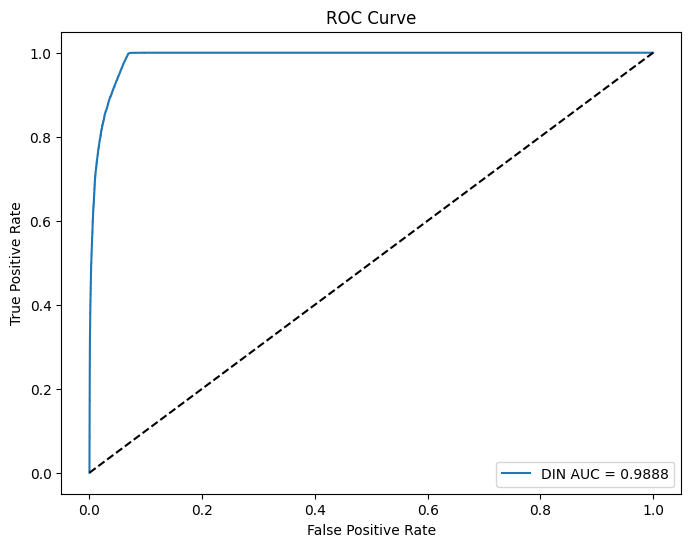

In [9]:
# 评估循环 (MovieLens 版本)
def evaluate_model(model, eval_data_list, item_pool, batch_size=64, neg_ratio=1): # 定义模型评估函数。 model: DIN 对象，DIN 模型实例。 eval_data_list: list，评估数据集列表。 item_pool: list，物品池列表。 batch_size: int，batch 大小。 neg_ratio: int，负采样比例。
    model.eval() # 将模型设置为评估模式。
    all_labels = [] # 初始化所有真实标签列表。 all_labels: list，所有真实标签。
    all_predictions = [] # 初始化所有预测概率列表。 all_predictions: list，所有预测概率。
    total_eval_loss = 0.0 # 初始化评估损失。 total_eval_loss: float，总评估损失。
    eval_batch_num = len(eval_data_list) // batch_size # 计算评估 batch 数量。 eval_batch_num: int，评估 batch 数量。

    with torch.no_grad(): # 在评估过程中禁用梯度计算。
        for batch_idx in range(eval_batch_num): # 遍历评估 batch。 batch_idx: int，batch 索引。
            eval_batch_data = generate_sample_data(eval_data_list, item_pool, batch_size=batch_size, start_index=batch_idx * batch_size, neg_ratio=neg_ratio) # 生成评估 batch 数据。 eval_batch_data: dict，评估 batch 数据字典。
            labels = eval_batch_data['label'] # 获取评估 batch 的标签。 labels: Tensor，评估 batch 标签。
            predictions = model(eval_batch_data['user_id'], # 模型预测。 predictions: Tensor，模型预测概率，维度为 (batch_size * (1 + neg_ratio))。
                              eval_batch_data['user_gender'],
                              eval_batch_data['user_age'],
                              eval_batch_data['user_occupation'],
                              eval_batch_data['item_id'],
                              eval_batch_data['item_genres'],
                              eval_batch_data['history_item_ids'],
                              eval_batch_data['target_item_id'])

            eval_loss = loss_fn(predictions, labels) # 计算评估 batch 的损失。 eval_loss: Tensor，评估 batch 损失。
            total_eval_loss += eval_loss.item() # 累加评估损失。
            all_labels.extend(labels.cpu().numpy()) # 将评估 batch 的真实标签添加到列表中。
            all_predictions.extend(predictions.cpu().numpy()) # 将评估 batch 的预测概率添加到列表中。

    avg_eval_loss = total_eval_loss / eval_batch_num # 计算平均评估损失。 avg_eval_loss: float，平均评估损失。
    auc_score = roc_auc_score(all_labels, all_predictions) # 计算 AUC 值。 auc_score: float，AUC 值。
    logloss_score = log_loss(torch.tensor(all_labels), torch.tensor(all_predictions)) # 计算 LogLoss 值。 logloss_score: float，LogLoss 值。

    print(f"Evaluation - Average Loss: {avg_eval_loss:.4f}, AUC: {auc_score:.4f}, LogLoss: {logloss_score:.4f}") # 打印评估指标。
    return all_labels, all_predictions, avg_eval_loss, auc_score, logloss_score # 返回所有真实标签、预测概率、平均评估损失、AUC 值和 LogLoss 值。


# 在训练完成后进行评估
print("开始评估...") # 打印开始评估信息。
all_labels, all_predictions, avg_eval_loss, auc_score, logloss_score = evaluate_model(model, eval_list, item_pool_encoded, batch_size=batch_size, neg_ratio=neg_ratio) # 调用评估函数进行模型评估。 all_labels: list，所有真实标签。 all_predictions: list，所有预测概率。 avg_eval_loss: float，平均评估损失。 auc_score: float，AUC 值。 logloss_score: float，LogLoss 值。
print("评估完成!") # 打印评估完成信息。

# 绘制 ROC 曲线
fpr, tpr, thresholds = roc_curve(all_labels, all_predictions) # 计算 ROC 曲线的 FPR 和 TPR。 fpr: ndarray，假正率。 tpr: ndarray，真正率。 thresholds: ndarray，阈值。
plt.figure(figsize=(8, 6)) # 创建 figure 对象，设置大小。 plt.figure: Figure 对象。
plt.plot(fpr, tpr, label=f'DIN AUC = {auc_score:.4f}') # 绘制 ROC 曲线，并添加 AUC 值标签。
plt.plot([0, 1], [0, 1], 'k--') # 绘制对角线作为随机分类器的基准。
plt.xlabel('False Positive Rate') # 设置 x 轴标签。
plt.ylabel('True Positive Rate') # 设置 y 轴标签。
plt.title('ROC Curve') # 设置图表标题。
plt.legend(loc='lower right') # 显示图例，并设置位置在右下角。
plt.show() # 显示 ROC 曲线图。
